In [133]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda, Layer

In [134]:
#import os
#os.environ['CUDA_VISIBLE_DEVICES']="1"

#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [135]:
#tf.shape(hidden_layer_1M)

In [136]:
class MyDenseLayer(Layer):

    def __init__(self, kernel_initilizer=tf.keras.initializers.Identity(), num_outputs=50, **kwargs):
        super(MyDenseLayer, self).__init__(**kwargs)
        self.kernel_initializer = tf.keras.initializers.get(kernel_initilizer)
        self.num_outputs = num_outputs

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self._b = self.add_weight(name='x', 
                                    shape=[int(input_shape[-1]),
                                         self.num_outputs],
                                    initializer=self.kernel_initializer, #'uniform',
                                    trainable=True)
        self._c = self.add_weight(name='x', 
                                    shape=[int(input_shape[-1]),
                                         self.num_outputs],
                                    initializer=self.kernel_initializer, #'uniform',
                                    trainable=True)
        self._d = self.add_weight(name='x', 
                                    shape=[
                                         self.num_outputs],
                                    initializer=tf.keras.initializers.Zeros(), #'uniform',
                                    trainable=True)

        super(MyDenseLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return tf.linalg.matmul(tf.nn.relu(x), self._b) - tf.linalg.matmul(tf.nn.relu(-x), self._c) + self._d

In [137]:
#Define the discriminator
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
hidden_layer_4 = Dense(50, activation='relu')(hidden_layer_3)
hidden_layer_5 = Dense(50, activation='relu')(hidden_layer_4)
hidden_layer_6 = Dense(50, activation='relu')(hidden_layer_5)
outputs = Dense(1, activation='sigmoid')(hidden_layer_6)
Discriminator = Model(inputs=inputs, outputs=outputs)
Discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

#Define the mapping function:
inputsM = Input((1, ))

initializer = tf.keras.initializers.Identity()

hidden_layer_1M = MyDenseLayer()(inputsM)
hidden_layer_2M = MyDenseLayer()(hidden_layer_1M)
#hidden_layer_3M = MyDenseLayer()(hidden_layer_2M)
#hidden_layer_4M = MyDenseLayer()(hidden_layer_3M)
#hidden_layer_5M = MyDenseLayer()(hidden_layer_4M)
#hidden_layer_6M = MyDenseLayer()(hidden_layer_5M)
#hidden_layer_4M = Dense(1, activation='linear', kernel_initializer=initializer)(hidden_layer_6M)
MappingFunc = Model(inputs=inputsM, outputs=hidden_layer_2M)

#Define the generator
inputsG = Input((2, ))
concatenate_layerG = Concatenate()([MappingFunc(inputsG[:,1:2]),inputsG[:,0:1]])
outputG = concatenate_layerG[:, 0]*concatenate_layerG[:, 1]
Generator = Model(inputs=inputsG, outputs=outputG)

#Define the full GAN for training
inputsGAN = Input((2, ))
GAN = Model(inputs=inputsGAN,outputs=Discriminator(Generator(inputsGAN)))
GAN.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [138]:
# generate n real samples with class labels
def generate_real_samples(n):
    rng = np.random.default_rng()
    x = rng.normal(0,1,n)
    y = np.ones((n, 1))
    c = [-1.5]*(n//4) + [1.5]*(n//4) + [0.5]*(n//4) + [-0.5]*(n//4) #np.random.uniform(-1.5,1.5,n)
    X = np.c_[x,c]
    rng.shuffle(X)
    return X, y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(real_samples,generator, n):
    # predict outputs
    X = np.c_[Generator.predict(real_samples),real_samples[:,1]]
    # create class labels
    y = np.zeros((n, 1))
    return X, y

In [140]:
m = 200
n_batch = m
n_epochs = 5*m
half_batch = int(n_batch / 2)
# manually enumerate epochs
for i in range(n_epochs):
    # prepare real samples
    x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(x_real, Generator, half_batch)
    Discriminator.train_on_batch(x_real[:,0], y_real)
    Discriminator.train_on_batch(x_fake[:,0], y_fake)
    Discriminator.trainable = False
    # update the generator via the discriminator's error
    loss = GAN.train_on_batch(x_real, np.ones(len(x_real)), return_dict=True)
    Discriminator.trainable = True
    #Discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    if(i%m == 0):
        print(i,MappingFunc.predict([[1]]))
        print(loss)

0 [[ 1.1037846  -0.15466575  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]]
{'loss': 0.4729461669921875, 'accuracy': 1.0}
200 [[ 1.2001477  -0.20981568  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         

In [141]:
MappingFunc.predict([[1.5]])

array([[ 1.9884238 , -0.41974616,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)

In [142]:
MappingFunc.predict([[-1.5]])

array([[-2.6807246, -0.570415 ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ]],
      dtype=float32)

In [143]:
MappingFunc.predict([[0.5]])

array([[ 0.40746218, -0.2474971 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)

In [144]:
MappingFunc.predict([[-0.5]])

array([[-1.1461543 , -0.33771017,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)

In [ ]:
preds = MappingFunc.predict([[c] for c in np.linspace(-2,2,20)])
plt.plot(np.linspace(-2,2,20),preds)

In [10]:
b_i = np.random.uniform(-1.5,1.5,m//10)
b_f = []
c_i = np.random.uniform(-1.5,1.5,m//10)
c_f = []


for j in range(m//10):
    preds = MappingFunc.predict([[c_i[j]]])
    c_f.append(preds[0,0])
    
        

ValueError: shape mismatch: objects cannot be broadcast to a single shape

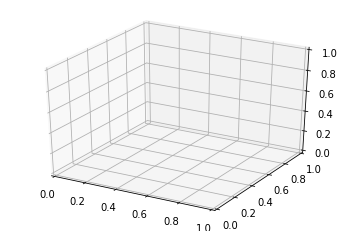

In [30]:
ax = plt.axes(projection='3d')
ax.scatter(c_i, c_f, b_f,
                c=b_f, cmap='viridis', linewidth=0.5)

Text(0, 0.5, 'final slope')

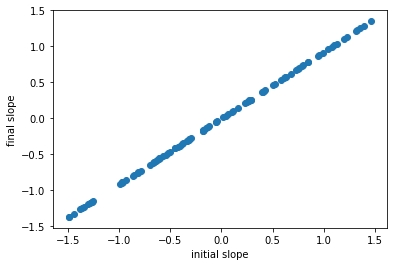

In [11]:
plt.scatter(c_i, c_f)
plt.xlabel("initial slope")
plt.ylabel("final slope")

In [33]:
#plt.scatter(b_i, b_f)
#plt.xlabel("initial intercept")
#plt.ylabel("final intercept")

In [34]:
x_real, y_real = generate_real_samples(10000)
x_fake, y_fake = generate_fake_samples(x_real, Generator, 10000)

(array([ 315.,  708., 1222., 1658., 1933., 1579., 1204.,  696.,  333.]),
 array([-2.        , -1.55555556, -1.11111111, -0.66666667, -0.22222222,
         0.22222222,  0.66666667,  1.11111111,  1.55555556,  2.        ]),
 <a list of 9 Patch objects>)

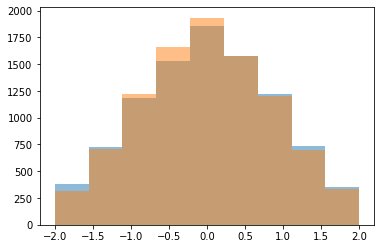

In [35]:
plt.hist(x_real[:,0],bins=np.linspace(-2,2,10),alpha=0.5)
plt.hist(x_fake[:,0],bins=np.linspace(-2,2,10),alpha=0.5)

In [36]:
np.mean(x_real[:,0])

-0.0012336223399872213

In [37]:
np.mean(x_fake[:,0])

0.0011748947770996892

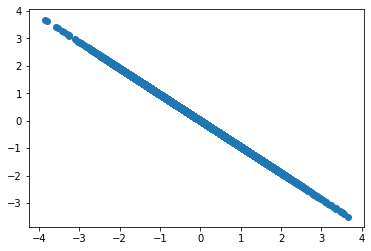

In [38]:
plt.scatter(x_real[:,0],x_fake[:,0])

In [127]:
X1 = np.random.normal(0, 1, 10000)
y1 = np.zeros(10000)
X2 = np.random.normal(-2, 1, 10000)
y2 = np.ones(10000)

In [128]:
#Define the mapping function:
inputsM = Input((1, ))

initializer = tf.keras.initializers.Identity()

hidden_layer_1M = MyDenseLayer()(inputsM)
hidden_layer_2M = MyDenseLayer()(hidden_layer_1M)
#hidden_layer_3M = MyDenseLayer()(hidden_layer_2M)
#hidden_layer_4M = MyDenseLayer()(hidden_layer_3M)
#hidden_layer_5M = MyDenseLayer()(hidden_layer_4M)
#hidden_layer_6M = MyDenseLayer()(hidden_layer_5M)
hidden_layer_7M = Dense(1, activation='sigmoid', kernel_initializer=initializer)(hidden_layer_2M)
MappingFunc = Model(inputs=inputsM, outputs=hidden_layer_7M)

In [129]:
MappingFunc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [130]:
MappingFunc.fit(np.concatenate([X1, X2]),np.concatenate([y1, y2]), epochs = 10, verbose=0)

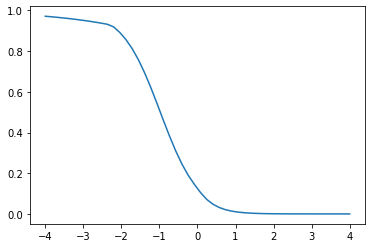

In [131]:
plt.plot(np.linspace(-4, 4, 50), MappingFunc.predict(np.linspace(-4, 4, 50)))

In [119]:
for i in range(8):
    print(np.shape(MappingFunc.get_weights()[i]))

(1, 50)
(1, 50)
(50,)
(50, 50)
(50, 50)
(50,)
(50, 1)
(1,)


In [112]:
print(MappingFunc.get_weights()[0])

[[0.78181195 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]]


In [113]:
print(MappingFunc.get_weights()[1])

[[0.6462336 0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.       ]]


In [114]:
print(MappingFunc.get_weights()[2])

[0.98516273 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [115]:
print(MappingFunc.get_weights()[4])

[[-0.6065227  0.         0.        ...  0.         0.         0.       ]
 [ 0.         1.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         1.        ...  0.         0.         0.       ]
 ...
 [ 0.         0.         0.        ...  1.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         1.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         1.       ]]


In [116]:
print(MappingFunc.get_weights()[7])

[0.3481868]


In [77]:
print(MappingFunc.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
my_dense_layer_36 (MyDenseLa (None, 50)                150       
_________________________________________________________________
my_dense_layer_37 (MyDenseLa (None, 50)                5050      
_________________________________________________________________
my_dense_layer_38 (MyDenseLa (None, 50)                5050      
_________________________________________________________________
my_dense_layer_39 (MyDenseLa (None, 50)                5050      
_________________________________________________________________
my_dense_layer_40 (MyDenseLa (None, 50)                5050      
_________________________________________________________________
my_dense_layer_41 (MyDenseLa (None, 50)                5050

In [60]:
def g(x, b, c, d):
    return tf.multiply(b,[tf.nn.relu(x)]) - tf.multiply(c, [tf.nn.relu(-x)]) + d

b = np.ones([50, 1])
c = np.ones([50, 1])
d = np.zeros([50])

In [62]:
print(g(-5.0, b, c, d))

tf.Tensor(
[[-5. -5. -5. ... -5. -5. -5.]
 [-5. -5. -5. ... -5. -5. -5.]
 [-5. -5. -5. ... -5. -5. -5.]
 ...
 [-5. -5. -5. ... -5. -5. -5.]
 [-5. -5. -5. ... -5. -5. -5.]
 [-5. -5. -5. ... -5. -5. -5.]], shape=(50, 50), dtype=float64)
